In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Term Structure of Interest Rates

In [2]:
def phi_t(a, b, lamda, t):
    phit = a + b*(((1-np.exp(-lamda*t))/(lamda*t))-np.exp(-lamda*t))
    return phit

def Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0):
    x = np.full((Nsim, Ntime+1), np.nan)
    y = np.full((Nsim, Ntime+1), np.nan)
    r = np.full((Nsim, Ntime+1), np.nan)
    phi = np.full((Nsim, Ntime+1), np.nan)
    phi[:,0] = a
    r[:,0] = a + x_0 + y_0
    x[:,0] = x_0
    y[:,0] = y_0
    dt = 1/252
    t = 0
    # Set initial x_0, y_0
    for i in range(Ntime):
        Z_1 = np.random.standard_normal(Nsim)
        Z_2 = np.random.standard_normal(Nsim)
        t = (i+1)*dt
        x[:,i+1] = x[:,i] - alpha*x[:,i]*dt + sigma*np.sqrt(dt)*Z_1
        y[:,i+1] = y[:,i] - beta*y[:,i]*dt + eta*np.sqrt(dt)*Z_2
        phi[:,i+1] = phi_t(a,b,lamda,t)
        r[:,i+1]= phi[:,i+1] + x[:,i+1] +y[:,i+1]
    Pt0 = np.mean(np.exp(-np.sum(r, axis=1)*dt))
    return x,y,r,Pt0

Set basic parameters

In [3]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
Ntime = 252*10
Nsim = 1000


x = np.full((Nsim, Ntime+1),np.nan)
y = np.full((Nsim, Ntime+1),np.nan)
r = np.full((Nsim, Ntime+1),np.nan)

x,y,r,pt0 = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0)



0.7339913500653639


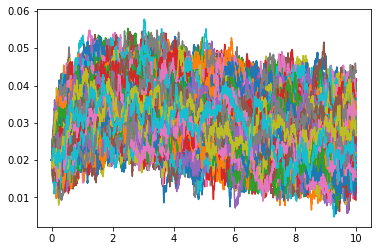

In [4]:
print(pt0)
t = np.linspace(0,10,Ntime+1)
for i in range(Nsim):
    plt.plot(t,r[i,:])
plt.show()

Q3 Use 10000 paths to obtain MC estimate of bond yields

In [5]:
# Simulation Method

def Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim, T, x_0, y_0):
    Pt0 = []
    yt = []
    Ntime = T*12*21
    dt = 1/252
    r = np.full((Nsim, Ntime+1), np.nan)
    r = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim,Ntime, x_0, y_0)[2]
    for i in range(T*12):
        length = (i+1)*21
        pt0 = np.mean(np.exp(-np.sum(r[:,0:length],axis=1)*dt))
        Pt0 += [pt0]
        yt += [np.log(1/pt0)/((i+1)/12)]
    
    return Pt0, yt
    

from scipy.integrate import quad
# Analytical Method
def integrand(sigma,eta,alpha,T,x,beta):
    mu_t = sigma*(1-np.exp(-beta*(T-x)))/beta
    nu_t = eta*((1-np.exp(-beta*(T-x)))/beta
    return mu_t**2 + nu_t**2


def Yields_ana(sigma,eta,alpha,T,beta):
    At = quad(integrand, lambda x: x, T, args=(sigma, eta, alpha, T, beta))
    #m_u = (1-np.exp(-beta*()))
    return At

In [16]:
from scipy.integrate import quad
def integrand(sigma,eta,alpha,T,x,beta):
    mu_t = sigma*(1-np.exp(-beta*(T-x)))/beta
    nu_t = eta*(1-np.exp(-beta*(T-x)))/beta
    return (mu_t**2 + nu_t**2)


def Yields_ana(sigma,eta,alpha,T,beta):
    At = quad(integrand, 0, T, args=(sigma, eta, alpha, T, beta))
    #m_u = (1-np.exp(-beta*()))
    return At

In [18]:
Yields_ana(0.01,0.005,3,1,1)[0]

0.24928978864574444

In [6]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 10
Nsim2 = 10000
Pt, yt = Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim2,T, x_0, y_0)


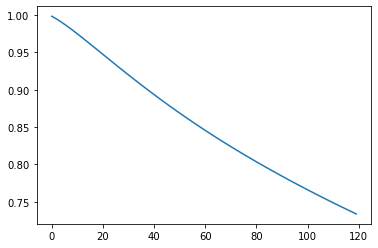

In [7]:
plt.plot(Pt)
#Pt

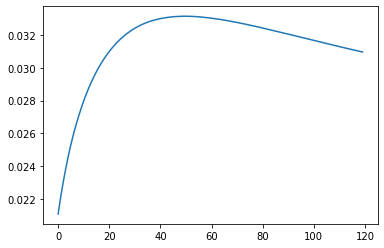

In [8]:
plt.plot(yt)